Populating the interactive namespace from numpy and matplotlib


Output()

Output()

MAE: 1.1400000000000001


<ipython-input-1-2da75c69318a>:141: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  home_results = scores_df[['hometeam', 'simulation', 'home_points', 'home_goals', 'away_goals']].groupby(['hometeam', 'simulation']).sum().reset_index()
<ipython-input-1-2da75c69318a>:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  away_results = scores_df[['awayteam', 'simulation', 'away_points', 'home_goals', 'away_goals']].groupby(['awayteam', 'simulation']).sum().reset_index()


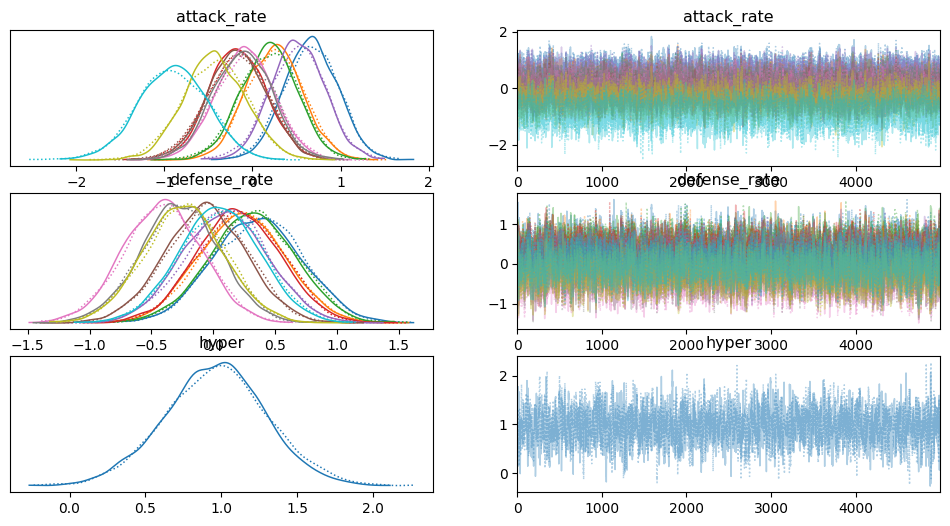

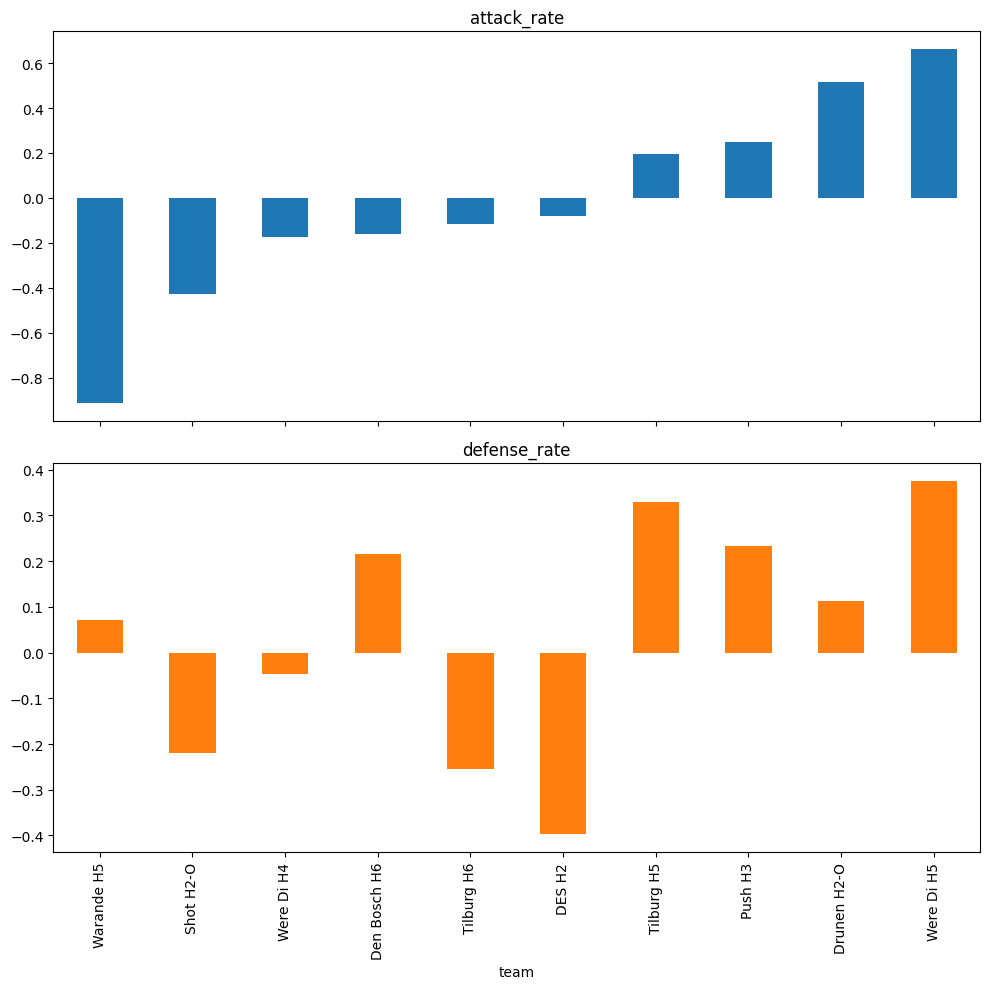

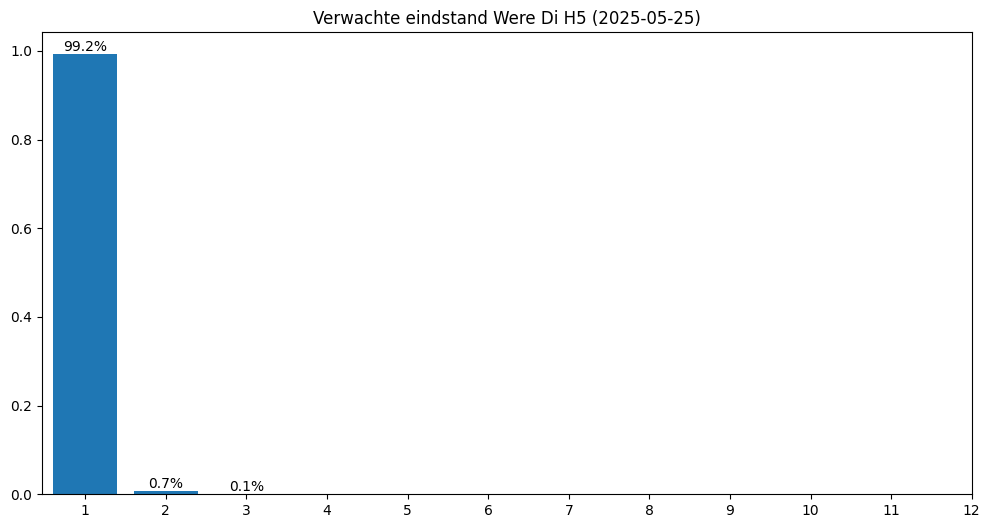

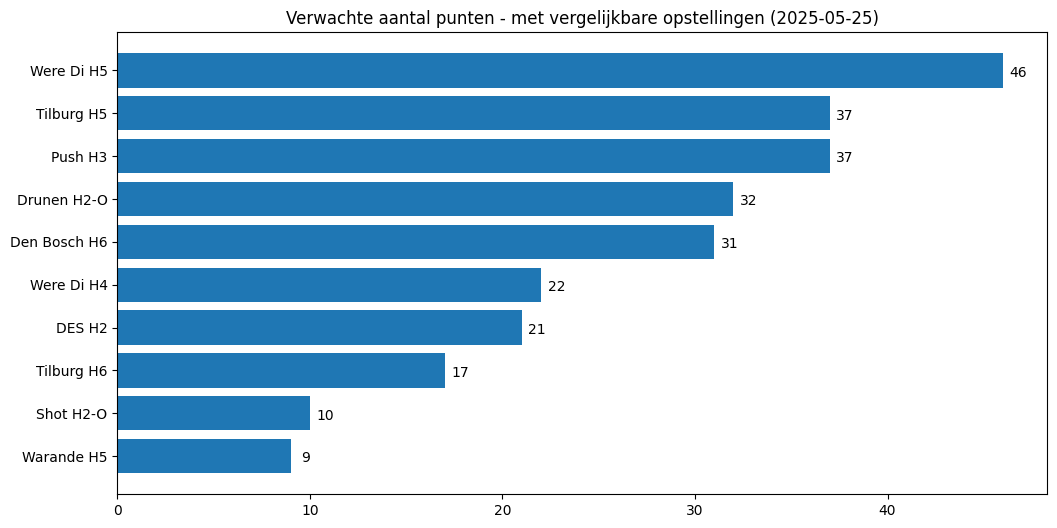

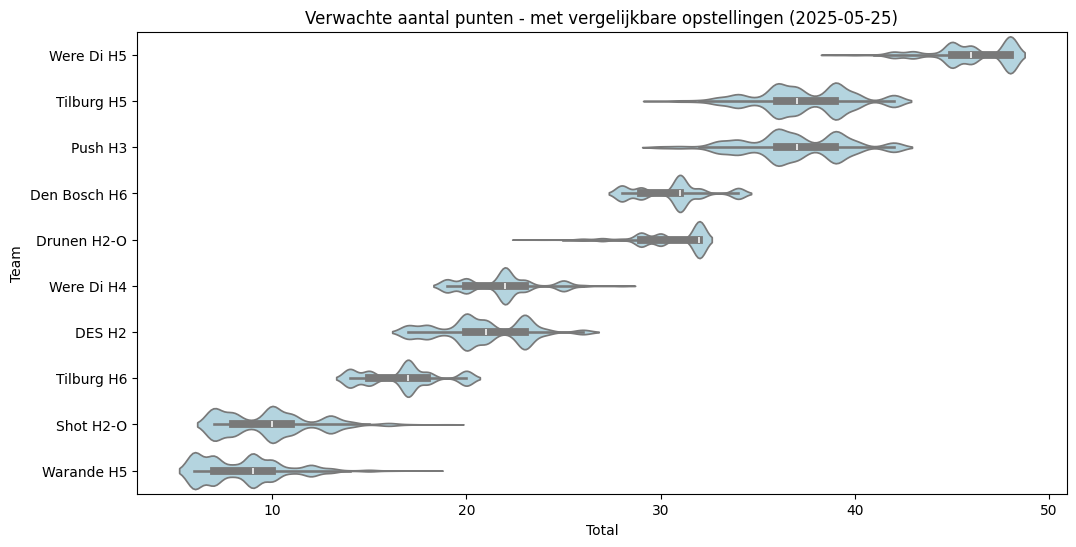

In [0]:
import pymc as pm
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(42)

SAMPLES = 5000
TUNE = 5000

TEAM = "Were Di H5"
COMPETITION = "N7816"
#SUBCOMPETITION = "N7"
SUBCOMPETITION = None

def get_data(url):
  response = requests.get(url).json()
  result = pd.DataFrame.from_dict(response['data'])
  if 'links' in response:
    while response['links']['next'] is not None:
      print(response['links']['next'])
      response = requests.get(response['links']['next'] + '&show_all=1').json()
      result = pd.concat([result, pd.DataFrame.from_dict(response['data'])])
  return result

if SUBCOMPETITION:
  subcomp_string = f"&competition_id={SUBCOMPETITION}"
else:
  subcomp_string = ""

upcoming_games = get_data(f"https://publicaties.hockeyweerelt.nl/mc/teams/{COMPETITION}/matches/upcoming?&show_all=1{subcomp_string}")
played_games = get_data(f"https://publicaties.hockeyweerelt.nl/mc/teams/{COMPETITION}/matches/official?=&show_all=1{subcomp_string}")
standing_raw = get_data(f"https://publicaties.hockeyweerelt.nl/mc/teams/{COMPETITION}/standing")

comp = pd.concat([upcoming_games, played_games])
comp['hometeam'] = comp['home_team'].str['name']
comp['awayteam'] = comp['away_team'].str['name']
comp = comp[['datetime', 'hometeam', 'awayteam', 'home_score', 'away_score']]

standing = pd.DataFrame.from_dict(standing_raw['standings'][0])
standing['team'] = standing['team'].str['name']

teams = set(standing['team'])

category_order = standing['team']
comp.hometeam = comp.hometeam.astype("category").cat.set_categories(category_order)
comp.awayteam = comp.awayteam.astype("category").cat.set_categories(category_order)
comp[['played']] = ~pd.isnull(comp[['home_score']])

n_teams = len(teams)
played = comp[comp.played]
not_played = comp[~comp.played]
scores = pd.concat([played['home_score'], played['away_score']], ignore_index=True)

with pm.Model() as model:
    hometeam = pm.Data("hometeam", played.hometeam.cat.codes.astype('int8').values)
    awayteam = pm.Data("awayteam", played.awayteam.cat.codes.astype('int8').values)
    hyper = pm.Normal('hyper', np.log(np.mean(scores)), 0.5)

    attack_rate = pm.Normal('attack_rate', 0, 1, shape = n_teams)
    defense_rate = pm.Normal('defense_rate', 0, 1, shape = n_teams)

    home_diff = (attack_rate[hometeam] - defense_rate[awayteam]) + hyper
    away_diff = (attack_rate[awayteam] - defense_rate[hometeam]) + hyper
    home_goals = pm.Poisson('home_goals', pm.math.exp(home_diff), observed = played.home_score.values.astype(int))
    away_goals = pm.Poisson('away_goals', pm.math.exp(away_diff), observed = played.away_score.values.astype(int))

    trace = pm.sample(SAMPLES, tune=TUNE)

pm.plot_trace(trace)

print("")

team_names = comp.hometeam.cat.categories
attack_rate = trace.posterior.attack_rate[1].to_pandas().median()
defense_rate = trace.posterior.defense_rate[1].to_pandas().median()

df = pd.concat([attack_rate, defense_rate], axis=1)
df.columns = ['attack_rate', 'defense_rate']
df.index = team_names
df.sort_values("attack_rate", inplace=True)
ax = df.plot.bar(subplots = True, figsize = (10, 10), legend = False)

plt.tight_layout()

with model:
    ppc = pm.sample_posterior_predictive(trace)

MAE = (np.mean(abs(played['home_score'] - np.median(ppc.posterior_predictive['home_goals'][1], axis=0))) +
np.mean(abs(played['away_score'] - np.median(ppc.posterior_predictive['away_goals'][1], axis=0)))) / 2

print(f"MAE: {MAE}") # An improvement would be to seperate test and training

import datetime

upcoming_games = comp[~comp.played].reset_index()
# Determine the number of upcoming games
n_upcoming_games = len(upcoming_games)

# Create arrays for hometeam and awayteam for upcoming games
upcoming_hometeam = upcoming_games.hometeam.cat.codes.astype('int8').values
upcoming_awayteam = upcoming_games.awayteam.cat.codes.astype('int8').values

# Create arrays for hyper from the trace
hyper_samples = trace.posterior.hyper[1]

# Predict goals for upcoming games
upcoming_home_diff = (
    (trace.posterior.attack_rate[1][:, upcoming_hometeam].T.values - trace.posterior.defense_rate[1][:, upcoming_awayteam].T.values) + hyper_samples.values
)
upcoming_away_diff = (
    (trace.posterior.attack_rate[1][:, upcoming_awayteam].T.values - trace.posterior.defense_rate[1][:, upcoming_hometeam].T.values) + hyper_samples.values
)

# Compute the Poisson parameter for upcoming games
predictions = {
    "home_goals": np.random.poisson(np.exp(upcoming_home_diff)),
    "away_goals": np.random.poisson(np.exp(upcoming_away_diff))
}

goals_dict = {}
for column in ['home_goals', 'away_goals']:
  goals = pd.DataFrame(predictions[column])
  goals[['hometeam']] = upcoming_games[['hometeam']]
  goals[['awayteam']] = upcoming_games[['awayteam']]
  goals[['datetime']] = upcoming_games[['datetime']]
  goals_dict[column] = pd.melt(goals, id_vars=['hometeam', 'awayteam', 'datetime'])
  goals_dict[column].columns = ['hometeam', 'awayteam', 'datetime', 'simulation', column]

scores_df = goals_dict['home_goals'].merge(goals_dict['away_goals'], on=['hometeam', 'awayteam', 'simulation', 'datetime'])
scores_df['home_win'] = scores_df['home_goals'] > scores_df['away_goals']
scores_df['draw'] = scores_df['home_goals'] == scores_df['away_goals']
scores_df['away_win'] = scores_df['home_goals'] < scores_df['away_goals']
scores_df['home_points'] = scores_df['home_win'] * 3 + scores_df['draw']
scores_df['away_points'] = scores_df['away_win'] * 3 + scores_df['draw']

home_results = scores_df[['hometeam', 'simulation', 'home_points', 'home_goals', 'away_goals']].groupby(['hometeam', 'simulation']).sum().reset_index()
home_results.rename(columns={"home_goals": "goals_for_home", "away_goals": "goals_against_home"}, inplace=True)
away_results = scores_df[['awayteam', 'simulation', 'away_points', 'home_goals', 'away_goals']].groupby(['awayteam', 'simulation']).sum().reset_index()
away_results.rename(columns={"home_goals": "goals_against_away", "away_goals": "goals_for_away"}, inplace=True)

added_points = home_results.merge(
    away_results,
    left_on=['hometeam', 'simulation'],
    right_on=['awayteam', 'simulation']
)
added_points['added_points'] = added_points['home_points'] + added_points['away_points']
added_points['added_goals_for'] = added_points['goals_for_home'] + added_points['goals_for_away']
added_points['added_goals_against'] = added_points['goals_against_home'] + added_points['goals_against_away']
added_points['team'] = added_points['hometeam']
result = standing[['team', 'points', 'goals_for', 'goals_against']].merge(added_points[['team', 'simulation', 'added_points', 'added_goals_for', 'added_goals_against']])
result['total'] = result['points'] + result['added_points']
result['goals_for'] = result['goals_for'] + result['added_goals_for']
result['goals_against'] = result['goals_against'] + result['added_goals_against']

result = pd.concat([group.sort_values(by=['total', 'goals_for', 'goals_against'], ascending=[False, False, True]).assign(position=range(1, len(group) + 1)) for name, group in result.groupby('simulation')], ignore_index=True)

print("")

bar_input = (result[result['team'] == TEAM]['position'].value_counts() / SAMPLES).sort_index()

fig, ax = plt.subplots(1, figsize=(12,6))
bar = ax.bar(bar_input.index, bar_input)
plt.xticks(range(1,13))
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height*100:.1f}%', ha='center', va='bottom')
plt.title(f"Verwachte eindstand {TEAM} ({datetime.date.today()})")

plt.show()
print("")

end_result = result.groupby('team')['total'].median().sort_values(ascending=True)

fig, ax = plt.subplots(1, figsize=(12,6))
bar = ax.barh(end_result.index, end_result)
for rect in bar:
    width = rect.get_width()
    plt.text(width + 0.8, rect.get_y()+ 0.185, f'{width:.0f}', ha='center', va='bottom')
plt.title(f"Verwachte aantal punten - met vergelijkbare opstellingen ({datetime.date.today()})")

plt.show()
print("")

position = []
teams = result.groupby('team')['total'].mean().sort_values(ascending=True).index.values
for team in np.sort(result['team'].unique()):
  position.append(np.where(team == teams)[0][0])

plt.figure(figsize=(12, 6))
sns.violinplot(x='total', y='team', data=result, order=teams[::-1], color='lightblue', density_norm='width')

plt.title(f"Verwachte aantal punten - met vergelijkbare opstellingen ({datetime.date.today()})")
plt.xlabel('Total')
plt.ylabel('Team')
plt.show()

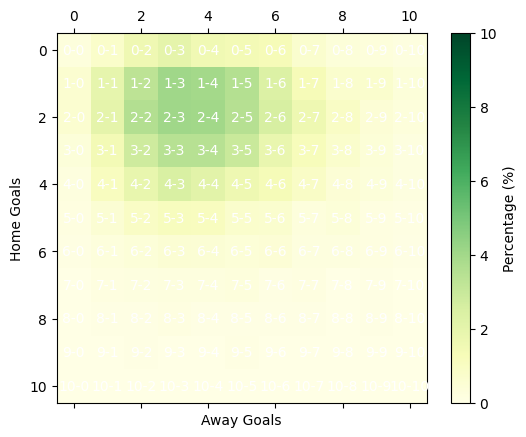

Komende wedstrijd: Push H3 vs Were Di H5
Verwachte score: 2-3
Verwachting dat we de nul houden: 10.0%
Kans op thuisoverwinning: 21.0%
Kans op gelijkspel: 13.0%
Kans op uitoverwinning: 66.0%


In [0]:
TEAM = "Were Di H5"

were_di_matches = scores_df[(scores_df['hometeam'] == TEAM) | (scores_df['awayteam'] == TEAM)]
next_game_date = were_di_matches.datetime.min()
next_were_di_match = were_di_matches[were_di_matches['datetime'] == next_game_date]

# Extract home and away goals
home_goals = next_were_di_match['home_goals'].values
away_goals = next_were_di_match['away_goals'].values

# Create a 2D histogram-like plot
fig, ax = plt.subplots()

# Create a grid for the matrix
max_home_goals = max(home_goals)
max_away_goals = max(away_goals)
matrix = np.zeros((max_home_goals + 1, max_away_goals + 1))

# Fill the matrix with the percentages
total_matches = len(home_goals)
for i in range(len(home_goals)):
    matrix[home_goals[i], away_goals[i]] += 1 / total_matches * 100

matrix = matrix[:11,:11]

# Create a heatmap with percentages
cmap = plt.colormaps['YlGn']  # Use 'YlGn' colormap for dark green
cax = ax.matshow(matrix, cmap=cmap, vmin=0, vmax=10)

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        if not np.isnan(matrix[i, j]):
            ax.text(j, i, f'{int(i)}-{int(j)}', va='center', ha='center', color='white')


# Set labels for the x and y axes
plt.xlabel('Away Goals')
plt.ylabel('Home Goals')

# Add a colorbar to the right of the matrix
cbar = fig.colorbar(cax)

# Format the colorbar labels as percentages
cbar.set_label('Percentage (%)')

# Show the plot
plt.show()

print(f"Komende wedstrijd: {next_were_di_match['hometeam'].iloc[0]} vs {next_were_di_match['awayteam'].iloc[0]}")
print(f"Verwachte score: {next_were_di_match['home_goals'].mode()[0]}-{next_were_di_match['away_goals'].mode()[0]}")
if next_were_di_match['hometeam'].iloc[0] == TEAM:
  clean_sheet = np.mean(next_were_di_match['away_goals'] == 0)
elif next_were_di_match['awayteam'].iloc[0] == TEAM:
  clean_sheet = np.mean(next_were_di_match['home_goals'] == 0)
else:
  print("Something is going wrong")
print(f"Verwachting dat we de nul houden: {round(clean_sheet * 100)}%")
print(f"Kans op thuisoverwinning: {round(np.mean(next_were_di_match['home_win']) * 100)}%")
print(f"Kans op gelijkspel: {round(np.mean(next_were_di_match['draw']) * 100)}%")
print(f"Kans op uitoverwinning: {round(np.mean(next_were_di_match['away_win']) * 100)}%")

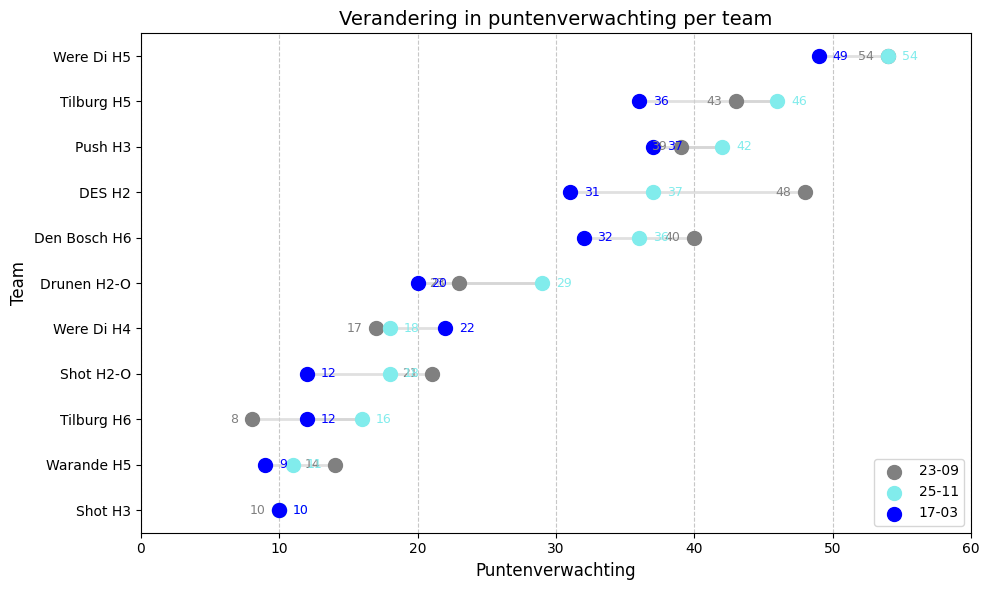

In [0]:
# Historical data
data = {
    "Team": [
        "Shot H3", "Warande H5", "Tilburg H6", "Shot H2-O",
        "Were Di H4", "Drunen H2-O", "Den Bosch H6",
        "DES H2", "Push H3", "Tilburg H5", "Were Di H5"
    ],
    "23-09": [10, 14, 8, 21, 17, 23, 40, 48, 39, 43, 54],
    "25-11": [10, 11, 16, 18, 18, 29, 36, 37, 42, 46, 54],
    "17-03": [10, 9, 12, 12, 22, 20, 32, 31, 37, 36, 49]
}
df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hlines(y=df['Team'], xmin=df['23-09'], xmax=df['25-11'], color='lightgray', alpha=0.7, linewidth=2)
ax.hlines(y=df['Team'], xmin=df['25-11'], xmax=df['17-03'], color='lightgray', alpha=0.7, linewidth=2)
ax.scatter(df['23-09'], df['Team'], color='gray', label='23-09', s=100, zorder=3)
ax.scatter(df['25-11'], df['Team'], color='#81ecec', label='25-11', s=100, zorder=3)
ax.scatter(df['17-03'], df['Team'], color='blue', label='17-03', s=100, zorder=3)

# Add labels and legend
for _, row in df.iterrows():
    ax.text(row['23-09'] - 1, row['Team'], f"{row['23-09']}", va='center', ha='right', fontsize=9, color='gray')
    ax.text(row['25-11'] + 1, row['Team'], f"{row['25-11']}", va='center', ha='left', fontsize=9, color='#81ecec')
    ax.text(row['17-03'] + 1, row['Team'], f"{row['17-03']}", va='center', ha='left', fontsize=9, color='blue')

ax.set_xlim(0, 60)
ax.set_title("Verandering in puntenverwachting per team", fontsize=14)
ax.set_xlabel("Puntenverwachting", fontsize=12)
ax.set_ylabel("Team", fontsize=12)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()